In [1]:
import torch 
from torchvision import transforms
from PIL import Image
import time

#import torch.nn as nn
import torch.optim as optim
torch.autograd.set_detect_anomaly(True)
from torch.utils.data import Dataset, DataLoader

import numpy as np
import matplotlib.pyplot as plt

import math

import copy
from typing import Optional, List

from torch.autograd import Variable
import torch.nn.functional as F
from torch import nn, Tensor

from torch.nn.utils.rnn import pad_sequence

from scipy.optimize import linear_sum_assignment

from ortools.graph.python import min_cost_flow

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [65]:
class PositionalEncoding(nn.Module):
    def __init__(self,
                 emb_size: int,
                 dropout: float,
                 maxlen: int = 5000):
        super(PositionalEncoding, self).__init__()
        den = torch.exp(- torch.arange(0, emb_size, 2)* math.log(10000) / emb_size)
        pos = torch.arange(0, maxlen).reshape(maxlen, 1)
        pos_embedding = torch.zeros((maxlen, emb_size))
        pos_embedding[:, 0::2] = torch.sin(pos * den)
        pos_embedding[:, 1::2] = torch.cos(pos * den)
        pos_embedding = pos_embedding.unsqueeze(-2)

        self.dropout = nn.Dropout(dropout)
        self.register_buffer('pos_embedding', pos_embedding)

    def forward(self, token_embedding: Tensor):
        #print('PE',self.pos_embedding[:token_embedding.size(0), :])
        return self.dropout(token_embedding + self.pos_embedding[:token_embedding.size(0), :])
    
    
def collate_fn(batch_len,PAD_IDX,train=True,recon=False,run=12):
    #print('batch',len(batch),batch)
    src1_batch, src2_batch, y_batch,d_batch = [], [], [], []
    for j in range(batch_len):
        
        if train:
            E1,E2,A,D=loadgraph()
        elif recon:
            E1,E2,A,D=loadgraph(recon=True, train=False,run=run,t_r=j)
            print('recon')
        else:
            E1,E2,A,D=loadgraph(train=False)
        #print('src_sample',src_sample)
        src1_batch.append(E1)
        #print('emb',src_batch[-1])
        src2_batch.append(E2)
        y_batch.append(A)
        d_batch.append(D)
        
        
    #print('src_batch',src_batch)
    #print('src_batch s',len(src_batch))
    src1_batch = pad_sequence(src1_batch, padding_value=PAD_IDX)
    #print('src_batch',src_batch)
    #print('src_batch s',src_batch.size())
    src2_batch = pad_sequence(src2_batch, padding_value=PAD_IDX)
    
    
    #print('src1',src1_batch[:,0,:])
    #print('y',y_batch)
    ##
    return src1_batch, src2_batch,y_batch,d_batch


def loadgraph(train=True,run=None,easy=False,recon=False,t_r=None):
    convert_tensor = transforms.ToTensor()
    if train:
        if run==None:
            run=np.random.randint(1,11)
        else: run=run
        E=np.loadtxt('./'+str(run)+'/'+'embed.txt')
        #print('E',E.shape)
        id,tt = np.loadtxt('./'+str(run)+'/'+'timetable.txt', delimiter='\t', usecols=(0,1), unpack=True)
        A=np.loadtxt('./'+str(run)+'_GT'+'/'+'A.txt')
        D=np.loadtxt('./'+str(run)+'/'+'D.txt')
        bg=A[0]
        for i in range(len(A)):
            for j in range(len(A)):
                if i>j:
                    A[i,j]=0
        #A=A+np.eye(len(A), dtype=int)
        
        t = np.random.randint(30) #!!!!!!!!how many t??
        id1 = id[tt==t].astype(int)
        if t==0:
            id1=id1[1:]
        id2 = id[tt==(t+1)].astype(int)
        
        #print(run,t,id1,id2)
        
        E1 = E[id1-1]
        E2 = E[id2-1]
       
        E_bg = E[0]
        
        E1=np.concatenate((np.array([E_bg]), E1), axis=0)
        E2=np.concatenate((np.array([E_bg]), E2), axis=0)
        
     
        
        A=A[id1-1]
        
        A=A[:,id2-1]
        
        
        D=D[id1-1]
        D=D[:,id2-1]
        
        
        
       
        
        #print(bg[id1-1])
        #print(bg[id2-1])
        
        
        A=np.concatenate((np.array([bg[id2-1]]), A), axis=0)
        
        bg_a=np.append(1,bg[id1-1])
        #print(bg_a)
        A=np.concatenate((np.array([bg_a]).T, A), axis=1)
        
        bg_b = np.append(0,np.zeros(len(bg[id1-1])))
        
        D=np.concatenate((np.array([np.zeros(len(bg[id2-1]))]), D), axis=0)
        D=np.concatenate((np.array([bg_b]).T, D), axis=1)
        
        #print(D)
        #print(np.dot(E1,E2.T))
        
        
        
        
    else:
        #print('eval')
        if run==None:
            run=np.random.randint(11,15)
        else: run=run
        E=np.loadtxt('./'+str(run)+'/'+'embed.txt')
        id,tt = np.loadtxt('./'+str(run)+'/'+'timetable.txt', delimiter='\t', usecols=(0,1), unpack=True)
        A=np.loadtxt('./'+str(run)+'_GT'+'/'+'A.txt')
        D=np.loadtxt('./'+str(run)+'/'+'D.txt')
        bg=A[0]
        for i in range(len(A)):
            for j in range(len(A)):
                if i>j:
                    A[i,j]=0
        #A=A+np.eye(len(A), dtype=int)
        
        t = np.random.randint(30) #!!!!!!!!how many t??
        id1 = id[tt==t].astype(int)
        if t==0:
            id1=id1[1:]
        id2 = id[tt==(t+1)].astype(int)
        
        #print(run,t,id1,id2)
        
        E1 = E[id1-1]
        E2 = E[id2-1]
       
        E_bg = E[0]
        
        E1=np.concatenate((np.array([E_bg]), E1), axis=0)
        E2=np.concatenate((np.array([E_bg]), E2), axis=0)
        
     
        
        A=A[id1-1]
        
        A=A[:,id2-1]
        
        #print(A)
        
        D=D[id1-1]
        D=D[:,id2-1]
        
       
        
        #print(bg[id1-1])
        #print(bg[id2-1])
        
        
        A=np.concatenate((np.array([bg[id2-1]]), A), axis=0)
        
        bg_a=np.append(1,bg[id1-1])
        A=np.concatenate((np.array([bg_a]).T, A), axis=1)
        
        bg_b = np.append(0,np.zeros(len(bg[id1-1])))
        
        D=np.concatenate((np.array([np.zeros(len(bg[id2-1]))]), D), axis=0)
        D=np.concatenate((np.array([bg_b]).T, D), axis=1)
        
        
    if recon: 
        run=run
        E=np.loadtxt('./'+str(run)+'/'+'embed.txt')
        id,tt = np.loadtxt('./'+str(run)+'/'+'timetable.txt', delimiter='\t', usecols=(0,1), unpack=True)
        A=np.loadtxt('./'+str(run)+'_GT'+'/'+'A.txt')
        D=np.loadtxt('./'+str(run)+'/'+'D.txt')
        for i in range(len(A)):
            for j in range(len(A)):
                if i>j:
                    A[i,j]=0
        #A=A+np.eye(len(A), dtype=int)
        
        
        #print(id)
        t = t_r
        id1 = id[tt==t].astype(int)
        if t==0:
            id1=id1[1:]
        id2 = id[tt==(t+1)].astype(int)
        
        #print(run,t,id1,id2)
        
        E1 = E[id1-1]
        E2 = E[id2-1]
       
        E_bg = E[0]
        
        E1=np.concatenate((np.array([E_bg]), E1), axis=0)
        E2=np.concatenate((np.array([E_bg]), E2), axis=0)
        
     
        
        A=A[id1-1]
        
        A=A[:,id2-1]
        
        
        
        D=D[id1-1]
        D=D[:,id2-1]
        
        
        #print(A)
        
        
        #print(bg[id1-1])
        #print(bg[id2-1])
        
        
        A=np.concatenate((np.array([bg[id2-1]]), A), axis=0)
        
        bg_a=np.append(1,bg[id1-1])
        A=np.concatenate((np.array([bg_a]).T, A), axis=1)
       
        #print(E1,E2)
        
        bg_b = np.append(0,np.zeros(len(bg[id1-1])))
    
    
    
        D=np.concatenate((np.array([np.zeros(len(bg[id2-1]))]), D), axis=0)
        D=np.concatenate((np.array([bg_b]).T, D), axis=1)
    
    
    if easy:
        n1=np.random.randint(3,6)
        n2=n1+np.random.randint(2)
        E1=np.ones((n1,6))
        E2=np.ones((n2,6))*3
        A=np.ones((n1,n2))
    
    
    
   
    
    D=D.astype(np.float32)
    
    vd = np.vectorize(d_mask_function,otypes=[float])
    
    D = vd(D,0.15,-2.0)
    
    
    E1=E1.astype(np.float32)
    E2=E2.astype(np.float32)
    A=A.astype(np.float32)
    #A=A.astype(np.float32)
    
    
    
    E1=convert_tensor(E1) 
    E2=convert_tensor(E2) 
    A=convert_tensor(A)
    D=convert_tensor(D)
    
    #print(E1[0].size(),E1[0])
    #print(E2[0].size(),E2[0])
    #print(A,A.size())
    #print('E',E.size())
    
    return E1[0],E2[0],A[0],D[0]

def create_mask(src,PAD_IDX):
    
    src= src[:,:,0]

    src_padding_mask = (src == PAD_IDX).transpose(0, 1)
    #print('src_padding_mask',src_padding_mask,src_padding_mask.size())
    return src_padding_mask


def train_easy(model, optimizer, loss_function, epochs,scheduler,verbose=True,eval=True):
    
    model.train()
    
    loss_over_time = []
    test_error = []
    perf=[]
    t0 = time.time()
    i=0
    while i < epochs:
        print(i)
        
        #u = np.random.random_integers(4998) #4998 for 3_GT
        src1, src2, y = collate_fn(10,-100)
        
        #print('src_batch',src1)
        #print('src_batch s',src1.size())
        
        src_padding_mask1=create_mask(src1,-100)
        src_padding_mask2=create_mask(src2,-100)
        
        optimizer.zero_grad()
        
        '''#trysimplesttrans'''
        
        #output=model(tgt,tgt)
        
        
        
        output1,output2 = model(src1,src2,src_padding_mask1,src_padding_mask2)  
        #output = model(src)   #!!!!!!!
        #imshow(src1)
        #imshow(tgt1)
        
        #print('out1',output1,output1.size())
        #print('out2',output2,output2.size())
        
        

 
        #print('train_sizes',src.size(),output[:,:n_nodes,:n_nodes].size(),y.size())
        
        
        epoch_loss = loss_function(output1, src1)
        epoch_loss.backward()
        optimizer.step()
        scheduler.step()
        if i % 5 == 0 and i>0:
            t1 = time.time()
            epochs_per_sec = 10/(t1 - t0) 
            if verbose:
                print(f"Epoch: {i} loss {epoch_loss.item()} @ {epochs_per_sec} epochs per second")
            loss_over_time.append(epoch_loss.item())
            t0 = t1
            np.savetxt('./'+'train_loss.txt', np.c_[loss_over_time],delimiter='\t',header='trainloss')
            perf.append(epochs_per_sec)
        try:
            print(c)
            d=len(loss_over_time)
            if np.sqrt((np.mean(loss_over_time[d-10:-1])-np.mean(loss_over_time[d-20:d-10]))**2) < np.std(loss_over_time[d-10:-1])/50:
                print('loss not reducing')
                print(np.mean(loss_over_time[d-10:-1])-np.mean(loss_over_time[d-20:d-10]))
                print(np.std(loss_over_time[d-10:-1])/10)
                print(d)
                break
        except:
            pass
        
        i=i+1
        
        '''
        if i % 5 == 0 and i>0:
        
    
        
            if eval:
                u = np.random.random_integers(490)
                src_t, tgt_t, y_t = loadgraph(easy=True)
                
                n_nodes=0
                for h in range(len(src_t[0])):
                    if torch.sum(src_t[0][h])!=0:
                        n_nodes=n_nodes+1
                
                max_len=len(src_t[0])
                
                output_t = model(src_t,tgt_t,n_nodes)

                test_loss = loss_function(output_t[:,:n_nodes,:n_nodes], y_t)

                test_error.append(test_loss.item())
                
                np.savetxt('./'+'test_loss.txt', np.c_[test_error],delimiter='\t',header='testloss')

            
        
        i=i+1
            
    print('Mean Performance', np.mean(perf))
    return model, loss_over_time, test_error
    '''
        
        
class makeAdja:
    def __init__(self):
        pass
        
    def forward(self,z:Tensor,
                mask1: Tensor,
                mask2: Tensor):
        Ad = []
        for i in range(z.size(0)):
            n=len([i for i, e in enumerate(mask1[i]) if e != True])
            m=len([i for i, e in enumerate(mask2[i]) if e != True])
            Ad.append(z[i,0:n,0:m])
        
        
        return Ad
    
    
    
def train_epoch(model, optimizer,loss_fn):
    model.train()
    losses = 0
    
    src1, src2, y,d = collate_fn(31,-100)
        
    src1= src1.to(DEVICE)
    src2= src2.to(DEVICE)
    
    src_padding_mask1=create_mask(src1,-100)
    src_padding_mask2=create_mask(src2,-100)
    
    Ad = model(src1,src2,src_padding_mask1,src_padding_mask2)

    optimizer.zero_grad()

   
    loss = loss_fn.loss(Ad,y)
    
    print(Ad[0],y[0])
    #print('l',loss)
    print('l',loss.item() / len(src1))
    
    loss.backward()

    optimizer.step()
    losses += loss.item()
    
    

    return losses / len(src1)



class Loss():
    def __init__(self,pen):
        self.pen=pen
        
    def loss (self,Ad,y):
        
        loss=0
        
        for i in range(len(Ad)):
            l = nn.CrossEntropyLoss()
            
            #print(Ad[i], y[i])
            
            s = l(Ad[i], y[i])
            
            loss=loss+s
                
        
        return loss
    


def evaluate(model,loss_fn):
    model.eval()
    losses = 0

    src1, src2, y,d = collate_fn(31,-100,train=False)
        
    src1= src1.to(DEVICE)
    src2= src2.to(DEVICE)
    
    src_padding_mask1=create_mask(src1,-100)
    src_padding_mask2=create_mask(src2,-100)
    
    Ad = model(src1,src2,src_padding_mask1,src_padding_mask2)

    
   
    loss = loss_fn.loss(Ad,y)
    
    losses += loss.item()
    
        

    return losses / len(src1)


def postprocess(A):
    pp_A=[]
    for i in range(len(A)):
        ind=torch.argmax(A[i], dim=0)
        B=np.zeros(A[i].shape)
        for j in range(len(ind)):
            B[ind[j],j]=1
        pp_A.append(B)
    return pp_A

def square(m):
    return m.shape[0] == m.shape[1]


def postprocess_2(Ad):
    pp_A=[]
    for h in range(len(Ad)):
        row_ind, col_ind = linear_sum_assignment(1-Ad[h].detach().numpy())

        z=np.zeros(Ad[h].shape)


        for i,j in zip(row_ind, col_ind):
            z[i,j]=1
    
        
        if square(z):
            pp_A.append(z)
            
        
        
        else:
            zero_col=np.where(~z.any(axis=0))[0]
            c_A=Ad[h].detach().numpy()
            z[:,zero_col] = c_A[:,zero_col]
            #print(z)
            pp_A.append(z)
        
            
       # else:
        #    z2 = np.zeros(Ad[h].shape)
        #    zero_col=np.where(~z.any(axis=0))[0]
            
         #   for k,l in zip(ind,zero_col):
         #       z2[k,l]=1
         #   pp_A.append(z+z2)  
        
    return pp_A



def postprocess_3(Ad):
    pp_A=[]
    
    row_ind, col_ind = linear_sum_assignment(1-Ad[0])
    
    print(1-Ad[0])
    print(row_ind, col_ind)
    
    z=np.zeros(Ad[0].shape)


    for i,j in zip(row_ind, col_ind):
        z[i,j]=1
    
    
    print(z)
    '''
    for h in range(len(Ad)):
        row_ind, col_ind = linear_sum_assignment(1-Ad[h])

        z=np.zeros(Ad[h].shape)


        for i,j in zip(row_ind, col_ind):
            z[i,j]=1
    
        
        if square(z):
            pp_A.append(z)
            
        
        
        else:
            zero_col=np.where(~z.any(axis=0))[0]
            c_A=Ad[h].detach().numpy()
            z[:,zero_col] = c_A[:,zero_col]
            #print(z)
            pp_A.append(z)
        
            
       # else:
        #    z2 = np.zeros(Ad[h].shape)
        #    zero_col=np.where(~z.any(axis=0))[0]
            
         #   for k,l in zip(ind,zero_col):
         #       z2[k,l]=1
         #   pp_A.append(z+z2) 
    '''
        
    return pp_A








def postprocess_linAss(Ad):
    pp_A=[]
    for h in range(len(Ad)):
        row_ind, col_ind = linear_sum_assignment(1-Ad[h].detach().numpy())

        z=np.zeros(Ad[h].shape)


        for i,j in zip(row_ind, col_ind):
            z[i,j]=1
    
        
        if square(z):
            pp_A.append(z)
        else:
            f=Ad[h].detach().numpy()
            l=np.ones(len(f))*2
            l=l.astype(int)
            
            
            f2=np.repeat(f, l, axis=0)
            row_ind, col_ind = linear_sum_assignment(1-f)
            z=np.zeros(f.shape)
            
            for i,j in zip(row_ind, col_ind):
                z[i,j]=1

            f2[0::2, :] = z[:] 

            row_ind_f, col_ind_f = linear_sum_assignment(1-f2)


            z3=np.zeros(f2.shape)


            for i,j in zip(row_ind_f, col_ind_f):
                z3[i,j]=1

            f_add = z3[0::2, :] + z3[1::2, :]
            
            pp_A.append(f_add)

        
    return pp_A





def postprocess_MinCostAss(Ad):
    pp_A=[]
    for h in range(len(Ad)):
        smcf = min_cost_flow.SimpleMinCostFlow()
        c_A = Ad[h]
        
        #left_n=c_A.size(0)
        #right_n=c_A.size(1)
        
        left_n=c_A.shape[0]
        right_n=c_A.shape[1]
        
        
        st=np.zeros(left_n)
        con= np.ones(right_n) 
        for v in range(left_n-1):
            con= np.append(con, np.ones(right_n)*(v+2))
        #print('con',con) 
        si = np.arange(left_n+1,left_n+right_n+1)
        start_nodes = np.concatenate((st,np.array(con),si))
        start_nodes = [int(x) for x in start_nodes ]
        print(start_nodes)
        
        st_e = np.arange(1,left_n+1)
        con_e = si
        for j in range(left_n-1):
            con_e = np.append(con_e,si)
            
        si_e = np.ones(right_n)*left_n+right_n+1
        
        end_nodes = np.concatenate((st_e,np.array(con_e),si_e))
        end_nodes = [int(x) for x in end_nodes ]
        print(end_nodes)
        
        cap_0 = np.ones(left_n)
        cap_0[0]=right_n-1
        
        cap_left=np.ones(right_n)
        cap_left[0]=right_n
        
        capacities = np.concatenate((cap_0,np.ones(len(con_e)),cap_left))
        capacities = [int(x) for x in capacities]
        print(capacities)
        
        c= c_A.flatten()                          
        #c=torch.flatten(c_A)
        #c=c.detach().numpy()  
                                    
                                    
        c=(1-c)*10**4
        
        #print(c)
                                    
        costs = np.concatenate((np.zeros(left_n),c,np.zeros(right_n)))
                                    
        costs = [int(x) for x in costs]
                                    
        print(costs)
        
        source = 0
        sink = left_n+right_n+1
        tasks = np.max([right_n,left_n])
        supplies= tasks 
        
        supplies=np.append(supplies,np.ones(left_n))
        supplies=np.append(supplies,np.zeros(right_n))
        
        #supplies=np.append(supplies,np.zeros(left_n+right_n))
        
        supplies=np.append(supplies,-tasks)
        
        supplies = [int(x) for x in supplies]
        print(supplies)
        print('____________________________________')
        # Add each arc.
        for i in range(len(start_nodes)):
            #print(start_nodes[i], end_nodes[i],capacities[i], costs[i])
            smcf.add_arc_with_capacity_and_unit_cost(start_nodes[i], end_nodes[i],
                                                 capacities[i], costs[i])
        # Add node supplies.
        for i in range(len(supplies)):
            smcf.set_node_supply(i, supplies[i])

        # Find the minimum cost flow between node 0 and node 10.
        status = smcf.solve()

        if status == smcf.OPTIMAL:
            #print('Total cost = ', smcf.optimal_cost())
            #print()
            row_ind=[]
            col_ind=[]
            for arc in range(smcf.num_arcs()):
                # Can ignore arcs leading out of source or into sink.
                if smcf.tail(arc) != source and smcf.head(arc) != sink:

                    # Arcs in the solution have a flow value of 1. Their start and end nodes
                    # give an assignment of worker to task.
                    if smcf.flow(arc) > 0:
                        #p#rint('Worker %d assigned to task %d.  Cost = %d Flow = %d' %
                        #      (smcf.tail(arc), smcf.head(arc), smcf.unit_cost(arc),smcf.flow(arc)))
                        row_ind.append(smcf.tail(arc)-1)
                        col_ind.append(smcf.head(arc)-left_n-1)
            z=np.zeros((left_n,right_n))
            
            for i,j in zip(row_ind, col_ind):
                z[i,j]=1
                    
            pp_A.append(z)
                    
                #else:
                    #print('Worker %d assigned to task %d.  Cost = %d  Flow = %d' %
                      #    (smcf.tail(arc), smcf.head(arc), smcf.unit_cost(arc),smcf.flow(arc)))
                
        else:
            print('There was an issue with the min cost flow input.')
            print(f'Status: {status}')
          



    return pp_A

        
'''

    start_nodes = np.zeros(c_A.size(0)) + [
        1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3
    ] + [4, 5, 6, 7]
    end_nodes = [1, 2, 3] + [4, 5, 6, 7, 4, 5, 6, 7, 4, 5, 6, 7] + [8,8,8,8]
    capacities = [2, 2, 2] + [
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1
    ] + [2, 2, 2, 2]
    costs = (
        [0, 0, 0] +
        c +
        [0, 0, 0 ,0])

    source = 0
    sink = 8
    tasks = 4
    supplies = [tasks, 0, 0, 0, 0, 0, 0, 0, -tasks]

    # Add each arc.
    for i in range(len(start_nodes)):
        smcf.add_arc_with_capacity_and_unit_cost(start_nodes[i], end_nodes[i],
                                                 capacities[i], costs[i])
    # Add node supplies.
    for i in range(len(supplies)):
        smcf.set_node_supply(i, supplies[i])

    # Find the minimum cost flow between node 0 and node 10.
    status = smcf.solve()

    if status == smcf.OPTIMAL:
        print('Total cost = ', smcf.optimal_cost())
        print()
        for arc in range(smcf.num_arcs()):
            # Can ignore arcs leading out of source or into sink.
            if smcf.tail(arc) != source and smcf.head(arc) != sink:

                # Arcs in the solution have a flow value of 1. Their start and end nodes
                # give an assignment of worker to task.
                if smcf.flow(arc) > 0:
                    print('Worker %d assigned to task %d.  Cost = %d Flow = %d' %
                          (smcf.tail(arc), smcf.head(arc), smcf.unit_cost(arc),smcf.flow(arc)))
                    
                #else:
                    #print('Worker %d assigned to task %d.  Cost = %d  Flow = %d' %
                      #    (smcf.tail(arc), smcf.head(arc), smcf.unit_cost(arc),smcf.flow(arc)))
                
    else:
        print('There was an issue with the min cost flow input.')
        print(f'Status: {status}')
            pp_A.append(f_add)

        
    return pp_A

'''

def make_reconstructed_edgelist(A,run):
    
    e_start=[1,2,3]
    e1=[]
    e2=[]
    
    
    for i in range(len(A)):
        M=A[i]
        
        
        
        
        for z in range(len(M)):
            for j in range(len(M[0])):
                if M[z,j]!=0:
                    print(z,e_start)
                    e1.append(int(e_start[z]))
                    e_mid=np.arange(e_start[-1]+1,e_start[-1]+len(M[0])+1)
                    print('e',e_mid)
                    e2.append(int(e_mid[j]))
        
        e_start=e_mid
        print('mid',e_mid)
    
    
    np.savetxt('./'+str(run)+'_GT'+'/'+'reconstruct.edgelist', np.c_[e1,e2], fmt='%i',delimiter='\t')
    return 0

def d_mask_function(x,r_core,alpha):
    if x < r_core:
        return 1
    else:
        return (x/r_core)**alpha
    
    
def complete_postprocess(Ad,d):
    
    m_Ad = []
    
    for h in range(len(Ad)):
        m_Ad.append(np.multiply(Ad[h].detach().numpy(),d[h].detach().numpy()))
        
   




    Ad = postprocess_MinCostAss(m_Ad)
    #Ad=postprocess_MinCostAss(Ad)



    return Ad

    

In [3]:
a = np.array([[1, 2], [3, 4]])
print(a)

b = np.array([[5, 6]])

np.concatenate((a, b), axis=0)


np.concatenate((a, b.T), axis=1)



loadgraph(run=1)

#print(stop)

[[1 2]
 [3 4]]


(tensor([[-0.0267,  0.1453, -0.0789,  0.0489, -0.1336, -0.2113, -0.1248, -0.0305,
           0.0090,  0.0653,  0.0127, -0.0921, -0.1803, -0.1376,  0.0537,  0.0335,
           0.0454,  0.1683, -0.0115,  0.0873, -0.1704, -0.0194,  0.0500,  0.1184,
           0.0970,  0.2225,  0.2227, -0.3404, -0.1093,  0.2371,  0.1008, -0.0813,
           0.0330, -0.1236, -0.2342, -0.0426, -0.0024,  0.0392,  0.1696,  0.4908,
           0.2130, -0.2124, -0.2138, -0.2236, -0.1587, -0.1036,  0.0067,  0.2044],
         [ 0.0687,  0.1966, -0.0357, -0.1585,  0.0976, -0.1245, -0.2950, -0.1241,
          -0.2730, -0.1747, -0.1520, -0.6228, -1.0923, -0.3612,  0.2027,  0.4117,
           0.0437, -0.3532,  0.3607,  0.4315,  0.3988,  0.1283, -0.0242,  0.1762,
           1.1894,  0.2108,  0.0277, -0.7799, -0.0039, -0.0396, -0.1685,  0.1206,
           0.3721, -0.3239, -0.1013,  0.0453,  0.2031,  0.0191,  0.4528,  0.0820,
           0.4366,  0.0410, -0.3237,  0.1421, -0.1213, -0.2404, -0.1972,  0.3101],
         [-0.1

In [31]:
class AdjacencyTransformer(nn.Module):
    def __init__(self,
                 num_encoder_layers: int,
                 emb_size: int,
                 nhead: int,
                 dim_feedforward: int = 512,
                 dropout: float = 0.1):
        super(AdjacencyTransformer, self).__init__()
        
        
        
        encoder_layer = nn.TransformerEncoderLayer(d_model=emb_size, nhead=nhead,dim_feedforward=dim_feedforward)
        decoder_layer = nn.TransformerDecoderLayer(d_model=emb_size, nhead=nhead,dim_feedforward=dim_feedforward)
        
        
        self.decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_encoder_layers)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_encoder_layers)
        
        self.positional_encoding = PositionalEncoding(emb_size, dropout=dropout)
        
        self.sig = torch.nn.Sigmoid()
        self.Ad = makeAdja()
        
        #self.lin = nn.Sequential(
        #    nn.Linear(input_dim, emb_size),
        #    nn.LeakyReLU())
        
        #self.lin2 = nn.Sequential(
        #    nn.Linear(emb_size, emb_size),
        #    nn.LeakyReLU())

    def forward(self,
                src_t1: Tensor,
                src_t2: Tensor,
                src_padding_mask1: Tensor,
                src_padding_mask2: Tensor):
        
        #print('trans_src_before_pos',src_t1,src_t1.size())
        #print('trans_src_toke',self.src_tok_emb(src),self.src_tok_emb(src).size())
        #src_t1 = self.lin(src_t1)
        #src_t2 = self.lin(src_t2)
        
        #src_t1 = self.lin2(src_t1)
        #src_t2 = self.lin2(src_t2)
        
        src1_emb = self.positional_encoding(src_t1)
        src2_emb = self.positional_encoding(src_t2)
        #print('trans_src',src1_emb,src1_emb.size())
        #print('trans_src_padd',src_padding_mask1,src_padding_mask1.size())
        out1 = self.encoder(src1_emb,src_key_padding_mask=src_padding_mask1)
        out2 = self.encoder(src2_emb,src_key_padding_mask=src_padding_mask2)
        
        out_dec1=self.decoder(out2, out1,tgt_key_padding_mask=src_padding_mask2,memory_key_padding_mask=src_padding_mask1)
        
        #out_dec2=self.decoder(out1, out2,tgt_key_padding_mask=src_padding_mask1,memory_key_padding_mask=src_padding_mask2)
        out_dec2=out1
        #out1=torch.transpose(out1,0,1)
        #out2=torch.transpose(out2,0,1)
        #out2=torch.transpose(out2,1,2)
        
        #z=self.sig(torch.bmm(out1,out2))
        
        out_dec2=torch.transpose(out_dec2,0,1)
        out_dec1=torch.transpose(out_dec1,0,1)
        out_dec1=torch.transpose(out_dec1,1,2)
        
        z=self.sig(torch.bmm(out_dec2,out_dec1))
        
        
        Ad=self.Ad.forward(z,src_padding_mask1,src_padding_mask2)


        
        return Ad
    
    
    
    
    
    
    
    
class AdjacencyNonlearn(nn.Module):
    def __init__(self,
                 num_encoder_layers: int,
                 emb_size: int,
                 nhead: int,
                 dim_feedforward: int = 512,
                 dropout: float = 0.1):
        super(AdjacencyNonlearn, self).__init__()
        
        
        
        encoder_layer = nn.TransformerEncoderLayer(d_model=emb_size, nhead=nhead,dim_feedforward=dim_feedforward)
        decoder_layer = nn.TransformerDecoderLayer(d_model=emb_size, nhead=nhead,dim_feedforward=dim_feedforward)
        
        
        self.decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_encoder_layers)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_encoder_layers)
        
        self.positional_encoding = PositionalEncoding(emb_size, dropout=dropout)
        
        self.sig = torch.nn.Sigmoid()
        self.Ad = makeAdja()
        
        #self.lin = nn.Sequential(
        #    nn.Linear(input_dim, emb_size),
        #    nn.LeakyReLU())
        
        #self.lin2 = nn.Sequential(
        #    nn.Linear(emb_size, emb_size),
        #    nn.LeakyReLU())

    def forward(self,
                src_t1: Tensor,
                src_t2: Tensor,
                src_padding_mask1: Tensor,
                src_padding_mask2: Tensor):
        
      
        
        out_dec2=torch.transpose(src_t1,0,1) 
        out_dec1=torch.transpose(src_t2,0,1)
        out_dec1=torch.transpose(out_dec1,1,2)
        
        z=self.sig(torch.bmm(out_dec2,out_dec1))
        
        
        Ad=self.Ad.forward(z,src_padding_mask1,src_padding_mask2)


        
        return Ad

In [32]:
input_dim=3

emb_size= 48 ###!!!!24 for n2v emb
nhead= 6    ####!!!! 6 for n2v emb
num_encoder_layers = 5


transformer = AdjacencyNonlearn(num_encoder_layers, emb_size, nhead)



for p in transformer.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

transformer = transformer.to(DEVICE)

loss_fn = Loss(pen=0)

optimizer = torch.optim.Adam(transformer.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)

In [66]:
from timeit import default_timer as timer
NUM_EPOCHS = 1000

loss_over_time=[]
test_error=[]

for epoch in range(1, NUM_EPOCHS+1):
    start_time = timer()
    train_loss = train_epoch(transformer, optimizer,loss_fn)
    end_time = timer()
    val_loss = evaluate(transformer,loss_fn)
    
    
    loss_over_time.append(train_loss)
    np.savetxt('./'+'train_loss_xyr.txt', np.c_[loss_over_time],delimiter='\t',header='trainloss')
    
    test_error.append(val_loss)
                
    np.savetxt('./'+'test_loss_xyr.txt', np.c_[test_error],delimiter='\t',header='testloss')

    
    print((f"Epoch: {epoch}, Train loss: {train_loss:.3f}, Val loss: {val_loss:.3f}, "f"Epoch time = {(end_time - start_time):.3f}s"))

tensor([[0.7648, 0.7795, 0.7933, 0.8034],
        [0.7931, 0.9024, 0.9992, 0.8748],
        [0.7753, 0.9989, 0.8849, 0.9672],
        [0.7946, 0.9605, 0.8529, 0.9984]]) tensor([[1., 0., 0., 0.],
        [0., 0., 1., 0.],
        [0., 1., 0., 0.],
        [0., 0., 0., 1.]])
l 4.006432028377757


RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

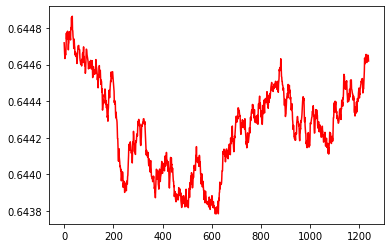

In [41]:
loss_over_time= np.loadtxt('./train_loss_AttTrack48.txt',skiprows=1, delimiter='\t', usecols=(0), unpack=True)
#test_error= np.loadtxt('./test_loss_AttTrack48.txt',skiprows=1, delimiter='\t', usecols=(0), unpack=True)


N=2000

plt.plot(np.convolve(np.log10(loss_over_time), np.ones(N)/N, mode='valid'),c='red')
#plt.plot(np.convolve(np.log10(test_error), np.ones(N)/N, mode='valid'))

In [68]:
src1, src2, y,d = collate_fn(10,-100,train=False)
        
src1= src1.to(DEVICE)
src2= src2.to(DEVICE)


    
src_padding_mask1=create_mask(src1,-100)
src_padding_mask2=create_mask(src2,-100)
    
Ad = transformer(src1,src2,src_padding_mask1,src_padding_mask2)
print(Ad[0])

Ad_real = complete_postprocess(Ad,d)
print(Ad_real[0])
print(y[0])
'''

print(Ad[0])
print(d[0])

#Ad = torch.mul(Ad, d)

f=Ad[0].detach().numpy()
g=d[0].detach().numpy()

print(np.multiply(f,g))
print(y[0])




Ad = postprocess_2(Ad)
print(Ad[0])
Ad=postprocess_MinCostAss(Ad)
print(Ad[0])
#torch.manual_seed(344)

#Ad = torch.rand(1,3,4)
#print(Ad[0])

f=Ad[0].detach().numpy()

l=np.ones(len(f))*2
l=l.astype(int)
f2=np.repeat(Ad[0].detach().numpy(), l, axis=0)

#print('f2',f2)

row_ind, col_ind = linear_sum_assignment(1-f)

#print(row_ind,col_ind)

z=np.zeros(f.shape)


for i,j in zip(row_ind, col_ind):
        z[i,j]=1

print(z)
        
f2[0::2, :] = z[:] 
        
#print('f2',f2) 


row_ind_f, col_ind_f = linear_sum_assignment(1-f2)


z3=np.zeros(f2.shape)


for i,j in zip(row_ind_f, col_ind_f):
        z3[i,j]=1


print(z3)

f_add = z3[0::2, :] + z3[1::2, :]

print('f_add',f_add)
        
z2 = np.zeros(f.shape)
zero_col=np.where(~z.any(axis=0))[0]
ind=torch.argmax(Ad[0][:,zero_col], dim=0)
        
print(Ad[0][:,zero_col])        
print(np.where(~z.any(axis=0))[0])
print(ind)
print(z)

for k,l in zip(ind,zero_col):
    z2[k,l]=1
    
print(z+z2)    

pp_A=postprocess(Ad)




#print(pp_A[0])
'''

tensor([[0.7568, 0.8246, 0.8182, 0.8218, 0.8209, 0.8239],
        [0.8227, 0.8756, 0.8853, 0.9984, 0.8936, 0.9028],
        [0.8273, 0.9983, 0.8994, 0.8774, 0.8847, 0.9985],
        [0.8317, 0.9984, 0.8964, 0.8814, 0.8947, 0.9983],
        [0.8311, 0.8930, 0.9988, 0.8929, 0.9988, 0.8680]])
[0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 6, 7, 8, 9, 10, 11]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 6, 7, 8, 9, 10, 11, 6, 7, 8, 9, 10, 11, 6, 7, 8, 9, 10, 11, 6, 7, 8, 9, 10, 11, 12, 12, 12, 12, 12, 12]
[5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 6, 1, 1, 1, 1, 1]
[0, 0, 0, 0, 0, 2431, 1753, 1817, 1781, 1791, 1760, 1773, 9327, 8494, 15, 8936, 9127, 1726, 17, 8351, 9120, 7661, 14, 1683, 15, 8858, 9387, 8313, 17, 1689, 8480, 12, 8586, 11, 8676, 0, 0, 0, 0, 0, 0]
[6, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, -6]
____________________________________
There was an issue with the min cost flow

IndexError: list index out of range

In [ ]:
#recon
run=14
src1, src2, y = collate_fn(31,-100,recon=True,train=False,run=run)

print(src1.size())
src1= src1.to(DEVICE)
src2= src2.to(DEVICE)
    
src_padding_mask1=create_mask(src1,-100)
src_padding_mask2=create_mask(src2,-100)
    
    
#transformer.load_state_dict(torch.load('AttTrack.pt',map_location=torch.device('cpu')))
transformer.eval()    
    

Ad = transformer(src1,src2,src_padding_mask1,src_padding_mask2)

Ad = postprocess_2(Ad)
pp_A=postprocess_MinCostAss(Ad)
#pp_A=postprocess_linAss(Ad)

print('y',y[0])
print('Ad',Ad[0])
print('pp',pp_A[0])

for i in range(5):
    print(pp_A[i])
    
    
make_reconstructed_edgelist(pp_A,run=run)

In [ ]:


x=np.arange(1,51,dtype=int)
y=np.arange(1,7,dtype=int)

l=[]
for i in range(5):
    z=np.random.choice(x, replace=False)
    l.append(z)
print(l)
s=np.random.random_integers(12)
print(s)
s=np.random.random_integers(12)
print(s)

In [ ]:
decoder_layer = nn.TransformerDecoderLayer(d_model=512, nhead=8)
transformer_decoder = nn.TransformerDecoder(decoder_layer, num_layers=6)
memory = torch.rand(10, 32, 512)
tgt = torch.rand(20, 32, 512)
out = transformer_decoder(tgt, memory)

print(out.shape)

In [ ]:
im = Image.open('/home/mo/Desktop/IWR/CellTracking/Fluo-C2DL-Huh7/02_GT/TRA/man_track001.tif')
im.show()

print(np.array(im))

In [ ]:
print(stop)

In [ ]:
p_drop=0.05
learning_rate=0.0001 #0.001 for cnn
epochs = 2000
emb_size=6   #!!!!!!!!!!!!!!!!!!!!
seq_length=104
d_m=12*20
nhead= 3
num_encoder_layers=4

model = AdjacencyTransformer(num_encoder_layers, emb_size, nhead)


#model=MiniLin(ch_size)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

scheduler=optim.lr_scheduler.MultiStepLR(optimizer,milestones=[250,750,1000,1500,2000,2500], gamma=0.5)


loss_function = nn.MSELoss(reduction='sum')

#loss_function = myL_loss(100,100)


model, loss_over_time, test_error = train_easy(model, optimizer, loss_function, epochs, scheduler,verbose=True,eval=True)

In [ ]:
transformer = Seq2SeqTransformer(NUM_ENCODER_LAYERS, NUM_DECODER_LAYERS, EMB_SIZE,
                                 NHEAD, SRC_VOCAB_SIZE, TGT_VOCAB_SIZE, FFN_HID_DIM)

for p in transformer.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

transformer = transformer.to(DEVICE)

loss_fn = torch.nn.CrossEntropyLoss(ignore_index=PAD_IDX)

optimizer = torch.optim.Adam(transformer.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)

In [ ]:
PAD_IDX=0



a = torch.ones(5, 6)*2
b = torch.ones(2, 6)
c = torch.ones(4, 6)
c2 = torch.ones(4, 6)/2

print(c)
print(c2)


#torch.matmul(d, e) 




d = pad_sequence([a, c])
e = pad_sequence([b, c2])




#print(d.size(),e.size())
#print('d',d[:,1,:],d[:,1,:].size())

mask1=create_mask(d,PAD_IDX)
mask2=create_mask(e,PAD_IDX)


d=torch.transpose(d,0,1)
e=torch.transpose(e,0,1)
e=torch.transpose(e,1,2)

#print('d2',d,d.size(),d[1,:,:])
#print('e2',e,e.size(),e[1,:,:])


#d=torch.reshape(d, (d.size(1), d.size(0), d.size(2)))
#e=torch.reshape(e, (e.size(1), e.size(2), e.size(0)))


#print(d,d.size())
#print('e',e,e.size(),e[0,:,:])



z=torch.bmm(d,e)

#print(z[0],z[1])
print(mask1[1],mask2[1])

#model = AdjacencyTransformer(num_encoder_layers, emb_size, nhead)

#out=model(d,e,mask1,mask2)
#print(out.size())


mA=makeAdja()
Ad=mA.forward(z,mask1,mask2)

print(Ad.size())

In [ ]:
print(stop)

In [ ]:
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torchtext.datasets import multi30k, Multi30k
from typing import Iterable, List


# We need to modify the URLs for the dataset since the links to the original dataset are broken
# Refer to https://github.com/pytorch/text/issues/1756#issuecomment-1163664163 for more info
multi30k.URL["train"] = "https://raw.githubusercontent.com/neychev/small_DL_repo/master/datasets/Multi30k/training.tar.gz"
multi30k.URL["valid"] = "https://raw.githubusercontent.com/neychev/small_DL_repo/master/datasets/Multi30k/validation.tar.gz"

SRC_LANGUAGE = 'de'
TGT_LANGUAGE = 'en'

# Place-holders
token_transform = {}
vocab_transform = {}


# Create source and target language tokenizer. Make sure to install the dependencies.
# pip install -U torchdata
# pip install -U spacy
# python -m spacy download en_core_web_sm
# python -m spacy download de_core_news_sm
token_transform[SRC_LANGUAGE] = get_tokenizer('spacy', language='de_core_news_sm')
token_transform[TGT_LANGUAGE] = get_tokenizer('spacy', language='en_core_web_sm')


# helper function to yield list of tokens
def yield_tokens(data_iter: Iterable, language: str) -> List[str]:
    language_index = {SRC_LANGUAGE: 0, TGT_LANGUAGE: 1}

    for data_sample in data_iter:
        yield token_transform[language](data_sample[language_index[language]])

# Define special symbols and indices
UNK_IDX, PAD_IDX, BOS_IDX, EOS_IDX = 0, 1, 2, 3
# Make sure the tokens are in order of their indices to properly insert them in vocab
special_symbols = ['<unk>', '<pad>', '<bos>', '<eos>']

for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
    # Training data Iterator
    train_iter = Multi30k(split='train', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
    # Create torchtext's Vocab object
    vocab_transform[ln] = build_vocab_from_iterator(yield_tokens(train_iter, ln),
                                                    min_freq=1,
                                                    specials=special_symbols,
                                                    special_first=True)

# Set UNK_IDX as the default index. This index is returned when the token is not found.
# If not set, it throws RuntimeError when the queried token is not found in the Vocabulary.
for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
    vocab_transform[ln].set_default_index(UNK_IDX)

In [ ]:
from torch import Tensor
import torch
import torch.nn as nn
from torch.nn import Transformer
import math
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# helper Module that adds positional encoding to the token embedding to introduce a notion of word order.
class PositionalEncoding(nn.Module):
    def __init__(self,
                 emb_size: int,
                 dropout: float,
                 maxlen: int = 5000):
        super(PositionalEncoding, self).__init__()
        den = torch.exp(- torch.arange(0, emb_size, 2)* math.log(10000) / emb_size)
        pos = torch.arange(0, maxlen).reshape(maxlen, 1)
        pos_embedding = torch.zeros((maxlen, emb_size))
        pos_embedding[:, 0::2] = torch.sin(pos * den)
        pos_embedding[:, 1::2] = torch.cos(pos * den)
        pos_embedding = pos_embedding.unsqueeze(-2)

        self.dropout = nn.Dropout(dropout)
        self.register_buffer('pos_embedding', pos_embedding)

    def forward(self, token_embedding: Tensor):
        print('PE',token_embedding.size(),self.pos_embedding[:token_embedding.size(0), :].size())
        return self.dropout(token_embedding + self.pos_embedding[:token_embedding.size(0), :])

# helper Module to convert tensor of input indices into corresponding tensor of token embeddings
class TokenEmbedding(nn.Module):
    def __init__(self, vocab_size: int, emb_size):
        super(TokenEmbedding, self).__init__()
        self.embedding = nn.Embedding(vocab_size, emb_size)
        self.emb_size = emb_size

    def forward(self, tokens: Tensor):
        return self.embedding(tokens.long()) * math.sqrt(self.emb_size)

# Seq2Seq Network
class Seq2SeqTransformer(nn.Module):
    def __init__(self,
                 num_encoder_layers: int,
                 num_decoder_layers: int,
                 emb_size: int,
                 nhead: int,
                 src_vocab_size: int,
                 tgt_vocab_size: int,
                 dim_feedforward: int = 512,
                 dropout: float = 0.1):
        super(Seq2SeqTransformer, self).__init__()
        self.transformer = Transformer(d_model=emb_size,
                                       nhead=nhead,
                                       num_encoder_layers=num_encoder_layers,
                                       num_decoder_layers=num_decoder_layers,
                                       dim_feedforward=dim_feedforward,
                                       dropout=dropout)
        self.generator = nn.Linear(emb_size, tgt_vocab_size)
        self.src_tok_emb = TokenEmbedding(src_vocab_size, emb_size)
        self.tgt_tok_emb = TokenEmbedding(tgt_vocab_size, emb_size)
        self.positional_encoding = PositionalEncoding(
            emb_size, dropout=dropout)

    def forward(self,
                src: Tensor,
                trg: Tensor,
                src_mask: Tensor,
                tgt_mask: Tensor,
                src_padding_mask: Tensor,
                tgt_padding_mask: Tensor,
                memory_key_padding_mask: Tensor):
        
        #print('trans_src_before_pos',src,src.size())
        #print('trans_src_toke',self.src_tok_emb(src),self.src_tok_emb(src).size())
        src_emb = self.positional_encoding(self.src_tok_emb(src))
        tgt_emb = self.positional_encoding(self.tgt_tok_emb(trg))
        print('trans_src',src_emb,src_emb.size())
        print('trans_src_padd',src_padding_mask,src_padding_mask.size())
        outs = self.transformer(src_emb, tgt_emb, src_mask, tgt_mask, None,
                                src_padding_mask, tgt_padding_mask, memory_key_padding_mask)
        print('outs',outs.size())
        return self.generator(outs)

    def encode(self, src: Tensor, src_mask: Tensor):
        return self.transformer.encoder(self.positional_encoding(
                            self.src_tok_emb(src)), src_mask)

    def decode(self, tgt: Tensor, memory: Tensor, tgt_mask: Tensor):
        return self.transformer.decoder(self.positional_encoding(
                          self.tgt_tok_emb(tgt)), memory,
                          tgt_mask)

In [ ]:
def generate_square_subsequent_mask(sz):
    mask = (torch.triu(torch.ones((sz, sz), device=DEVICE)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask


def create_mask(src, tgt):
    print('src_size',src.size())
    src_seq_len = src.shape[0]
    tgt_seq_len = tgt.shape[0]

    tgt_mask = generate_square_subsequent_mask(tgt_seq_len)
    src_mask = torch.zeros((src_seq_len, src_seq_len),device=DEVICE).type(torch.bool)

    src_padding_mask = (src == PAD_IDX).transpose(0, 1)
    print('src_padding_mask',src_padding_mask,src_padding_mask.size())
    tgt_padding_mask = (tgt == PAD_IDX).transpose(0, 1)
    return src_mask, tgt_mask, src_padding_mask, tgt_padding_mask

In [ ]:
torch.manual_seed(0)

SRC_VOCAB_SIZE = len(vocab_transform[SRC_LANGUAGE])
TGT_VOCAB_SIZE = len(vocab_transform[TGT_LANGUAGE])
EMB_SIZE = 512
NHEAD = 8
FFN_HID_DIM = 512
BATCH_SIZE = 128
NUM_ENCODER_LAYERS = 3
NUM_DECODER_LAYERS = 3

transformer = Seq2SeqTransformer(NUM_ENCODER_LAYERS, NUM_DECODER_LAYERS, EMB_SIZE,
                                 NHEAD, SRC_VOCAB_SIZE, TGT_VOCAB_SIZE, FFN_HID_DIM)

for p in transformer.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

transformer = transformer.to(DEVICE)

loss_fn = torch.nn.CrossEntropyLoss(ignore_index=PAD_IDX)

optimizer = torch.optim.Adam(transformer.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)

In [ ]:


# helper function to club together sequential operations
def sequential_transforms(*transforms):
    def func(txt_input):
        for transform in transforms:
            txt_input = transform(txt_input)
        return txt_input
    return func

# function to add BOS/EOS and create tensor for input sequence indices
def tensor_transform(token_ids: List[int]):
    return torch.cat((torch.tensor([BOS_IDX]),
                      torch.tensor(token_ids),
                      torch.tensor([EOS_IDX])))

# src and tgt language text transforms to convert raw strings into tensors indices
text_transform = {}
for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
    text_transform[ln] = sequential_transforms(token_transform[ln], #Tokenization
                                               vocab_transform[ln], #Numericalization
                                               tensor_transform) # Add BOS/EOS and create tensor


# function to collate data samples into batch tesors
def collate_fn(batch):
    #print('batch',len(batch),batch)
    src_batch, tgt_batch = [], []
    for src_sample, tgt_sample in batch:
        #print('src_sample',src_sample)
        src_batch.append(text_transform[SRC_LANGUAGE](src_sample.rstrip("\n")))
        #print('emb',src_batch[-1])
        tgt_batch.append(text_transform[TGT_LANGUAGE](tgt_sample.rstrip("\n")))
        
    #print('src_batch',src_batch)
    #print('src_batch s',len(src_batch))
    src_batch = pad_sequence(src_batch, padding_value=PAD_IDX)
    #print('src_batch',src_batch)
    #print('src_batch s',src_batch.size())
    tgt_batch = pad_sequence(tgt_batch, padding_value=PAD_IDX)
    return src_batch, tgt_batch

In [ ]:
from torch.utils.data import DataLoader

def train_epoch(model, optimizer):
    model.train()
    losses = 0
    train_iter = Multi30k(split='train', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
    train_dataloader = DataLoader(train_iter, batch_size=BATCH_SIZE, collate_fn=collate_fn)

    for src, tgt in train_dataloader:
        src = src.to(DEVICE)
        tgt = tgt.to(DEVICE)

        tgt_input = tgt[:-1, :]
        
        
        #print('trainsrc',src,src.size())

        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)
        
        #print('trainsrc_padd',src_padding_mask,src_padding_mask.size())

        logits = model(src, tgt_input, src_mask, tgt_mask,src_padding_mask, tgt_padding_mask, src_padding_mask)

        optimizer.zero_grad()

        tgt_out = tgt[1:, :]
        loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
        loss.backward()

        optimizer.step()
        losses += loss.item()

    return losses / len(train_dataloader)


def evaluate(model):
    model.eval()
    losses = 0

    val_iter = Multi30k(split='valid', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
    val_dataloader = DataLoader(val_iter, batch_size=BATCH_SIZE, collate_fn=collate_fn)

    for src, tgt in val_dataloader:
        src = src.to(DEVICE)
        tgt = tgt.to(DEVICE)

        tgt_input = tgt[:-1, :]

        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)

        logits = model(src, tgt_input, src_mask, tgt_mask,src_padding_mask, tgt_padding_mask, src_padding_mask)

        tgt_out = tgt[1:, :]
        loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
        losses += loss.item()

    return losses / len(val_dataloader)

In [ ]:
from timeit import default_timer as timer
NUM_EPOCHS = 18

for epoch in range(1, NUM_EPOCHS+1):
    start_time = timer()
    train_loss = train_epoch(transformer, optimizer)
    end_time = timer()
    val_loss = evaluate(transformer)
    print((f"Epoch: {epoch}, Train loss: {train_loss:.3f}, Val loss: {val_loss:.3f}, "f"Epoch time = {(end_time - start_time):.3f}s"))


# function to generate output sequence using greedy algorithm
def greedy_decode(model, src, src_mask, max_len, start_symbol):
    src = src.to(DEVICE)
    src_mask = src_mask.to(DEVICE)

    memory = model.encode(src, src_mask)
    ys = torch.ones(1, 1).fill_(start_symbol).type(torch.long).to(DEVICE)
    for i in range(max_len-1):
        memory = memory.to(DEVICE)
        tgt_mask = (generate_square_subsequent_mask(ys.size(0))
                    .type(torch.bool)).to(DEVICE)
        out = model.decode(ys, memory, tgt_mask)
        out = out.transpose(0, 1)
        prob = model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim=1)
        next_word = next_word.item()

        ys = torch.cat([ys,
                        torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=0)
        if next_word == EOS_IDX:
            break
    return ys


# actual function to translate input sentence into target language
def translate(model: torch.nn.Module, src_sentence: str):
    model.eval()
    src = text_transform[SRC_LANGUAGE](src_sentence).view(-1, 1)
    num_tokens = src.shape[0]
    src_mask = (torch.zeros(num_tokens, num_tokens)).type(torch.bool)
    tgt_tokens = greedy_decode(
        model,  src, src_mask, max_len=num_tokens + 5, start_symbol=BOS_IDX).flatten()
    return " ".join(vocab_transform[TGT_LANGUAGE].lookup_tokens(list(tgt_tokens.cpu().numpy()))).replace("<bos>", "").replace("<eos>", "")

In [ ]:
print(translate(transformer, "Eine Gruppe von Menschen steht vor einem Iglu ."))